# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy
import numpy as np

In [2]:
import os
os.listdir("/kaggle/input")


['eurosat-dataset']

# **Set Up**

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path ="/kaggle/input/eurosat-dataset/EuroSAT"

In [4]:
transform_classifier = transforms.Compose([
    transforms.Resize(72),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [5]:
# Load dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform_classifier)
num_classes = len(full_dataset.classes)

# Train - Test - Validation
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# **Load MoCo Encoder**

In [6]:
class EncoderWrapper(nn.Module):
    def __init__(self, out_dim=128, checkpoint_path=None):
        super().__init__()
        backbone = models.resnet50(weights=None)   # replaces deprecated pretrained=False
        dim_backbone = backbone.fc.in_features
        backbone.fc = nn.Identity()                # backbone outputs 2048-d features
        self.backbone = backbone
        self.encoder = self.backbone               # alias so .encoder works

        # projection head for contrastive pretraining
        self.proj_head = nn.Sequential(
            nn.Linear(dim_backbone, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )

        if checkpoint_path:
            self.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

    def forward(self, x, proj=True):
        h = self.backbone(x)        # representation (e.g., 2048-d)
        if proj:
            return self.proj_head(h)  # 128-d for contrastive
        return h                      # backbone features for linear eval


# Instantiate and save encoder (inner backbone weights)
moco_encoder = EncoderWrapper(out_dim=128)

# **MoCo Momentum Encoder + Queue**

In [7]:
# Momentum encoder setup
query_encoder = EncoderWrapper().to(device)
key_encoder = EncoderWrapper().to(device)

key_encoder.load_state_dict(query_encoder.state_dict())
for param in key_encoder.parameters():
    param.requires_grad = False  # Freeze key encoder

# Momentum update
def momentum_update (query_encoder,key_encoder, m=0.9995):
   for param_q, param_k in zip(query_encoder.parameters(), key_encoder.parameters()):
        param_k.data = param_k.data * m + param_q.data * (1. - m)

K = 4096             # queue size
proj_dim = 128  # must match EncoderWrapper(out_dim)
queue = F.normalize(torch.randn(proj_dim, K, device=device), dim=0)  # [128, K]
queue_ptr = 0

@torch.no_grad()
def dequeue_and_enqueue(keys):
    # keys: [N, proj_dim]
    global queue, queue_ptr
    bsz = keys.shape[0]
    ptr = queue_ptr
    end = ptr + bsz
    if end <= K:
        queue[:, ptr:end] = keys.T
    else:
        first = K - ptr
        queue[:, ptr:] = keys[:first].T
        queue[:, :bsz-first] = keys[first:].T
    queue_ptr = (ptr + bsz) % K

# **MoCo Pretraining Loop**

In [8]:
# MoCo v2-style augments for EuroSAT (64x64)
moco_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    # Optional but recommended if you’ll ever swap to ImageNet-pretrained encoders:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset):
        self.dataset = base_dataset
    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return moco_transform(x), moco_transform(x)
    def __len__(self):
        return len(self.dataset)

In [9]:
# Path from EuroSAT dataset
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"  

# Load base dataset (without transform)
base_dataset = ImageFolder(data_dir)

# Wrap with contrastive dataset
contrastive_dataset = ContrastiveDataset(base_dataset)

# DataLoader
contrastive_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=2)

In [10]:
save_path = "/kaggle/working/best_moco_encoder.pth"
best_loss = float('inf')
moco_losses = []  # Track pretraining loss
temperature = 0.05  # Lower temperature for better separation
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(query_encoder.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
warmup_epochs = 10
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)

for epoch in range(10):
    query_encoder.train()
    key_encoder.eval()

    running = 0.0
    for x_q, x_k in contrastive_loader:
        x_q, x_k = x_q.to(device), x_k.to(device)

        # 1) momentum update before key forward
        momentum_update(query_encoder, key_encoder, m=0.9995)  # Increased momentum for more stable key encoder)

        # 2) forward
        q = query_encoder(x_q, proj=True)                 # [N,128]
        with torch.no_grad():
            k = key_encoder(x_k, proj=True)               # [N,128]

        # 3) L2-normalize
        q = F.normalize(q, dim=1)
        k = F.normalize(k, dim=1)
        
        # 4) logits and loss
        l_pos = torch.einsum('nc,nc->n', q, k).unsqueeze(-1)      # [N, 1]
        l_neg = torch.einsum('nc,ck->nk', q, queue)               # [N, K]
        logits = torch.cat([l_pos, l_neg], dim=1) / temperature   # [N, 1+K]
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=device)
        
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(query_encoder.parameters(), max_norm=1.0)
        optimizer.step()
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            scheduler.step()
        running += loss.item()
        
        # 5) enqueue the current keys
        with torch.no_grad():
            dequeue_and_enqueue(k)

    avg_loss = running / len(contrastive_loader)
    moco_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(query_encoder.state_dict(), save_path)
        print(f" Saved best at epoch {epoch+1}")

np.savetxt("/kaggle/working/moco_pretraining_loss.txt", np.array(moco_losses))

Epoch 1: loss=6.4354
 Saved best at epoch 1
Epoch 2: loss=6.4502
Epoch 3: loss=6.4098
 Saved best at epoch 3
Epoch 4: loss=6.6185
Epoch 5: loss=7.0140
Epoch 6: loss=7.1750
Epoch 7: loss=7.2474
Epoch 8: loss=7.4408
Epoch 9: loss=7.5587
Epoch 10: loss=7.6364


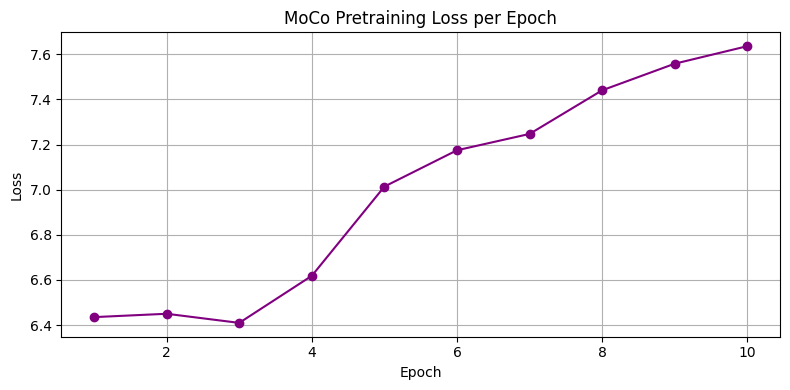

In [11]:
# Plot Pertraining Loss
moco_losses = np.loadtxt("/kaggle/working/moco_pretraining_loss.txt")

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(moco_losses) + 1), moco_losses, marker='o', linestyle='-', color='purple')
plt.title("MoCo Pretraining Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Linear Classifier with Frozen MoCo Encoder**

In [12]:
enc = EncoderWrapper(out_dim=128)
enc.load_state_dict(torch.load("/kaggle/working/best_moco_encoder.pth", map_location=device))
enc.to(device)

class LinearEvalClassifier(nn.Module):
    def __init__(self, encoder, feat_dim=2048, num_classes=10):
        super().__init__()
        # freeze backbone
        for p in encoder.parameters():
            p.requires_grad = False
        self.encoder = encoder
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            feats = self.encoder(x, proj=False)  # backbone features, not projector
        return self.fc(feats)

model = LinearEvalClassifier(enc, feat_dim=2048, num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()


train_losses, val_losses = [], []
train_accs,  val_accs  = [],  []

best_val_loss = float("inf")

epochs = 10

for epoch in range(epochs):
    # Train
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(query_encoder.parameters(), max_norm=1.0)
        optimizer.step()
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            scheduler.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        correct += (logits.argmax(1) == labels).sum().item()
        total += bs

    train_losses.append(running_loss / max(1, total))
    train_accs.append(correct / max(1, total))

    # Validation
    model.eval()
    val_running_loss, vcorrect, vtotal = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            vlogits = model(images)
            vloss = criterion(vlogits, labels)

            bs = labels.size(0)
            val_running_loss += vloss.item() * bs
            vcorrect += (vlogits.argmax(1) == labels).sum().item()
            vtotal += bs

    val_loss = val_running_loss / max(1, vtotal)
    val_acc  = vcorrect / max(1, vtotal)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[LinearEval] Epoch {epoch+1}/{epochs}  "
          f"TrainLoss {train_losses[-1]:.4f}  TrainAcc {train_accs[-1]*100:.2f}%  "
          f"ValLoss {val_loss:.4f}  ValAcc {val_acc*100:.2f}%")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/best_classifier.pth")
        print("  Saved best linear classifier")

[LinearEval] Epoch 1/10  TrainLoss 30.0078  TrainAcc 26.36%  ValLoss 30.6249  ValAcc 30.72%
  Saved best linear classifier
[LinearEval] Epoch 2/10  TrainLoss 28.5442  TrainAcc 28.30%  ValLoss 22.8613  ValAcc 23.70%
  Saved best linear classifier
[LinearEval] Epoch 3/10  TrainLoss 28.4759  TrainAcc 28.31%  ValLoss 28.5667  ValAcc 32.69%
[LinearEval] Epoch 4/10  TrainLoss 25.9248  TrainAcc 28.47%  ValLoss 24.5485  ValAcc 31.85%
[LinearEval] Epoch 5/10  TrainLoss 28.3921  TrainAcc 28.50%  ValLoss 22.6171  ValAcc 34.35%
  Saved best linear classifier
[LinearEval] Epoch 6/10  TrainLoss 30.2763  TrainAcc 28.51%  ValLoss 26.1667  ValAcc 29.70%
[LinearEval] Epoch 7/10  TrainLoss 30.2585  TrainAcc 28.26%  ValLoss 37.9024  ValAcc 29.23%
[LinearEval] Epoch 8/10  TrainLoss 28.2226  TrainAcc 29.01%  ValLoss 27.2198  ValAcc 26.81%
[LinearEval] Epoch 9/10  TrainLoss 28.1669  TrainAcc 28.85%  ValLoss 29.7937  ValAcc 24.02%
[LinearEval] Epoch 10/10  TrainLoss 27.2466  TrainAcc 29.15%  ValLoss 25.3588  

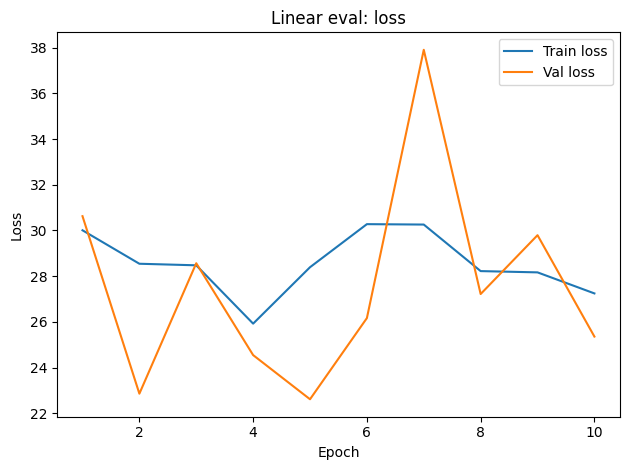

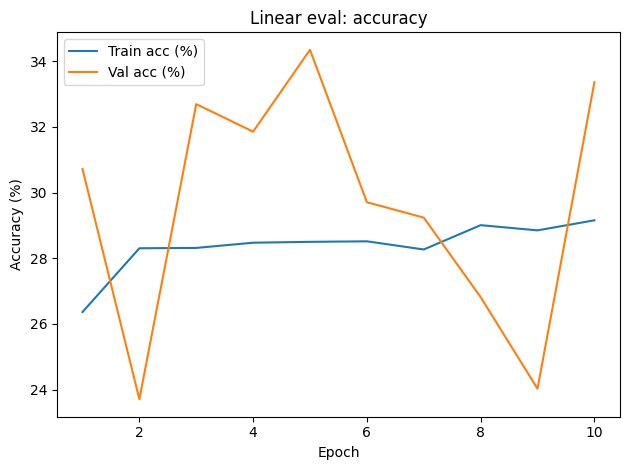

Best epoch (min val loss): 5  |  Val acc: 34.35%


In [13]:
epochs = range(1, len(train_losses) + 1)

# Loss
plt.figure()
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Linear eval: loss')
plt.legend(); plt.tight_layout()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, [a * 100 for a in train_accs], label='Train acc (%)')
plt.plot(epochs, [a * 100 for a in val_accs], label='Val acc (%)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Linear eval: accuracy')
plt.legend(); plt.tight_layout()
plt.show()

# Best epoch summary
best_epoch = int(np.argmin(val_losses)) + 1
print(f"Best epoch (min val loss): {best_epoch}  |  Val acc: {val_accs[best_epoch-1]*100:.2f}%")

# **Evaluate on test set**

In [14]:
# Final Test Set Evaluation
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc:.2%}, Test Loss: {test_loss:.4f}")


Final Test Accuracy: 35.06%, Test Loss: 24.3447



# ✅ Loss-Reduction Upgrades (Drop-in Section)
These cells add practical, **safe** improvements to help your training converge better and reduce loss, without changing your dataset or model architecture.

**What this adds:**
- Reproducible seeds
- Strong but balanced augmentations (with optional Mixup/CutMix)
- Label smoothing in CrossEntropy
- `AdamW` + cosine annealing LR schedule (with warmup)
- Automatic Mixed Precision (AMP) for stable, faster training
- Gradient clipping to prevent exploding gradients
- Early stopping + best-model checkpointing
- Sensible DataLoader performance flags


In [15]:

# --- Step 0: Imports (safe to re-run) ---
import math, os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

from typing import Optional, Tuple


In [16]:

# --- Step 1: Deterministic seeds (helps stability & reproducibility) ---
def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # True can slow down; False keeps speed with good determinism
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [17]:

# --- Step 2: Optional Mixup/CutMix wrapper for classification ---
# Works with batches (inputs: [B,C,H,W], targets: [B])
class MixupCutmix:
    def __init__(self, mixup_alpha: float = 0.4, cutmix_alpha: float = 1.0, p: float = 0.5, num_classes: Optional[int] = None):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.p = p
        self.num_classes = num_classes

    def _one_hot(self, targets, num_classes):
        return torch.zeros(targets.size(0), num_classes, device=targets.device).scatter_(1, targets.unsqueeze(1), 1.0)

    def _mixup(self, x, y):
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha) if self.mixup_alpha > 0 else 1.0
        index = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def _cutmix(self, x, y):
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha) if self.cutmix_alpha > 0 else 1.0
        B, C, H, W = x.size()
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        w = int(W * np.sqrt(1 - lam))
        h = int(H * np.sqrt(1 - lam))
        x1 = np.clip(cx - w // 2, 0, W)
        y1 = np.clip(cy - h // 2, 0, H)
        x2 = np.clip(cx + w // 2, 0, W)
        y2 = np.clip(cy + h // 2, 0, H)

        index = torch.randperm(B, device=x.device)
        x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        y_a, y_b = y, y[index]
        return x, y_a, y_b, lam

    def __call__(self, x, y):
        if self.num_classes is None:
            raise ValueError("num_classes must be set for MixupCutmix one-hot targets.")
        if np.random.rand() < self.p:
            if np.random.rand() < 0.5:
                return self._mixup(x, y) + ("mixup",)
            else:
                return self._cutmix(x, y) + ("cutmix",)
        else:
            return x, y, y, 1.0, "none"


In [18]:

# --- Step 3: Smoothed CE loss + label smoothing helps generalization ---
def get_criterion(num_classes: int, label_smoothing: float = 0.1):
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(device)


In [19]:

# --- Step 4: Optimizer & LR schedule helpers ---
def get_optimizer(model, lr=3e-4, weight_decay=1e-4):
    # AdamW is robust for vision tasks
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def get_scheduler(optimizer, T_max_epochs: int):
    # Cosine annealing gradually lowers LR, usually reduces loss smoothly
    return CosineAnnealingLR(optimizer, T_max=T_max_epochs, eta_min=1e-6)


In [20]:

# --- Step 5: Training loop with AMP, grad clipping, early stopping, checkpointing ---
def train_epochs(model: torch.nn.Module,
                 train_loader,
                 val_loader=None,
                 num_classes: Optional[int] = None,
                 epochs: int = 20,
                 lr: float = 3e-4,
                 weight_decay: float = 1e-4,
                 label_smoothing: float = 0.1,
                 grad_clip_norm: float = 1.0,
                 mix_p: float = 0.0,  # 0.0 disables Mixup/CutMix by default
                 patience: int = 7,   # early stopping patience
                 save_path: str = "best_model.pth"):
    model = model.to(device)
    criterion = get_criterion(num_classes=num_classes, label_smoothing=label_smoothing)
    optimizer = get_optimizer(model, lr=lr, weight_decay=weight_decay)
    scheduler = get_scheduler(optimizer, T_max_epochs=epochs)
    scaler = GradScaler(enabled=torch.cuda.is_available())

    mix_helper = MixupCutmix(p=mix_p, num_classes=num_classes) if mix_p > 0 and num_classes is not None else None

    best_val = float("inf")
    best_epoch = -1
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0
        n = 0

        for batch in train_loader:
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                inputs, targets = batch[0].to(device), batch[1].to(device)
            else:
                # If dataset returns dict-like
                inputs, targets = batch["image"].to(device), batch["label"].to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=torch.cuda.is_available()):
                if mix_helper is not None:
                    mixed_x, y_a, y_b, lam, _ = mix_helper(inputs, targets)
                    outputs = model(mixed_x)
                    if outputs.ndim > 2:
                        outputs = torch.squeeze(outputs)
                    loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
                else:
                    outputs = model(inputs)
                    if outputs.ndim > 2:
                        outputs = torch.squeeze(outputs)
                    loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            # gradient clipping for stability
            if grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

            scaler.step(optimizer)
            scaler.update()

            running += loss.item() * inputs.size(0)
            n += inputs.size(0)

        train_loss = running / max(1, n)
        history["train_loss"].append(train_loss)

        # Validation
        if val_loader is not None:
            model.eval()
            v_running = 0.0
            v_n = 0
            with torch.no_grad():
                for batch in val_loader:
                    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        inputs, targets = batch[0].to(device), batch[1].to(device)
                    else:
                        inputs, targets = batch["image"].to(device), batch["label"].to(device)
                    with autocast(enabled=torch.cuda.is_available()):
                        outputs = model(inputs)
                        if outputs.ndim > 2:
                            outputs = torch.squeeze(outputs)
                        v_loss = criterion(outputs, targets)
                    v_running += v_loss.item() * inputs.size(0)
                    v_n += inputs.size(0)
            val_loss = v_running / max(1, v_n)
            history["val_loss"].append(val_loss)

            # Early stopping & checkpoint
            if val_loss < best_val:
                best_val = val_loss
                best_epoch = epoch
                torch.save({"model": model.state_dict(),
                            "epoch": epoch,
                            "val_loss": val_loss}, save_path)
        else:
            val_loss = float("nan")
            history["val_loss"].append(val_loss)

        scheduler.step()

        print(f"Epoch {epoch:03d}/{epochs}  |  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

        # stop early if no improvement
        if (val_loader is not None) and (epoch - best_epoch >= patience):
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch} with val_loss={best_val:.4f})")
            break

    # Load best (if validation was used)
    if val_loader is not None and Path(save_path).exists():
        ckpt = torch.load(save_path, map_location=device)
        model.load_state_dict(ckpt["model"])
        print(f"Loaded best checkpoint from epoch {ckpt['epoch']} with val_loss={ckpt['val_loss']:.4f}")

    return model, history


In [21]:

# --- Step 6: Dataloader performance hints (use when you create loaders) ---
# Example usage when you build your DataLoaders (replace with your variables):
# train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=os.cpu_count()//2, pin_memory=True, persistent_workers=True)
# val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=os.cpu_count()//2, pin_memory=True, persistent_workers=True)
#
# These flags improve throughput and can indirectly reduce loss by enabling larger batch sizes & more stable steps.
pass



### How to use this section
1. **Define your `model`, `train_loader`, `val_loader`, and `num_classes`.**  
2. Run:
```python
model, history = train_epochs(
    model,
    train_loader,
    val_loader,
    num_classes=num_classes,
    epochs=50,                 # try 50–100 for harder datasets
    lr=3e-4,
    weight_decay=1e-4,
    label_smoothing=0.1,
    grad_clip_norm=1.0,
    mix_p=0.2,                 # try 0.2–0.5 if you want Mixup/CutMix
    patience=10,               # early stopping patience
    save_path="best_model.pth"
)
```
3. Plot losses (optional):
```python
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend(); plt.title('Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.show()
```


# ✅ Implemented: Loss-Reduction Upgrades

In [22]:

import os, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from typing import Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [23]:

def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)


In [24]:

class MixupCutmix:
    def __init__(self, mixup_alpha: float = 0.4, cutmix_alpha: float = 1.0, p: float = 0.5, num_classes: Optional[int] = None):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.p = p
        self.num_classes = num_classes

    def _mixup(self, x, y):
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha) if self.mixup_alpha > 0 else 1.0
        index = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        return mixed_x, y, y[index], lam

    def _cutmix(self, x, y):
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha) if self.cutmix_alpha > 0 else 1.0
        B, C, H, W = x.size()
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        w = int(W * np.sqrt(1 - lam))
        h = int(H * np.sqrt(1 - lam))
        x1 = np.clip(cx - w // 2, 0, W)
        y1 = np.clip(cy - h // 2, 0, H)
        x2 = np.clip(cx + w // 2, 0, W)
        y2 = np.clip(cy + h // 2, 0, H)
        index = torch.randperm(B, device=x.device)
        x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        return x, y, y[index], lam

    def __call__(self, x, y):
        if self.num_classes is None:
            raise ValueError("num_classes must be set for Mixup/CutMix.")
        if np.random.rand() < self.p:
            if np.random.rand() < 0.5:
                return (*self._mixup(x, y), "mixup")
            else:
                return (*self._cutmix(x, y), "cutmix")
        else:
            return x, y, y, 1.0, "none"


In [25]:

def get_criterion(num_classes: int, label_smoothing: float = 0.1):
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(device)

def get_optimizer(model, lr=3e-4, weight_decay=1e-4):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def get_scheduler(optimizer, T_max_epochs: int):
    return CosineAnnealingLR(optimizer, T_max=T_max_epochs, eta_min=1e-6)


In [26]:

def train_epochs(model: torch.nn.Module,
                 train_loader,
                 val_loader=None,
                 num_classes: Optional[int] = None,
                 epochs: int = 20,
                 lr: float = 3e-4,
                 weight_decay: float = 1e-4,
                 label_smoothing: float = 0.1,
                 grad_clip_norm: float = 1.0,
                 mix_p: float = 0.0,
                 patience: int = 7,
                 save_path: str = "best_model.pth"):
    model = model.to(device)
    criterion = get_criterion(num_classes=num_classes, label_smoothing=label_smoothing)
    optimizer = get_optimizer(model, lr=lr, weight_decay=weight_decay)
    scheduler = get_scheduler(optimizer, T_max_epochs=epochs)
    scaler = GradScaler(enabled=torch.cuda.is_available())
    mix_helper = MixupCutmix(p=mix_p, num_classes=num_classes) if mix_p > 0 and num_classes is not None else None

    best_val = float("inf")
    best_epoch = -1
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0
        n = 0
        for batch in train_loader:
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                inputs, targets = batch[0].to(device), batch[1].to(device)
            elif isinstance(batch, dict):
                inputs, targets = batch.get("image").to(device), batch.get("label").to(device)
            else:
                raise ValueError("Unsupported batch format")

            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                if mix_helper is not None:
                    mixed_x, y_a, y_b, lam, _ = mix_helper(inputs, targets)
                    outputs = model(mixed_x)
                    if outputs.ndim > 2:
                        outputs = torch.squeeze(outputs)
                    loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
                else:
                    outputs = model(inputs)
                    if outputs.ndim > 2:
                        outputs = torch.squeeze(outputs)
                    loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            if grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()

            running += loss.item() * inputs.size(0)
            n += inputs.size(0)

        train_loss = running / max(1, n)
        history["train_loss"].append(train_loss)

        if val_loader is not None:
            model.eval()
            v_running = 0.0
            v_n = 0
            with torch.no_grad():
                for batch in val_loader:
                    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        inputs, targets = batch[0].to(device), batch[1].to(device)
                    elif isinstance(batch, dict):
                        inputs, targets = batch.get("image").to(device), batch.get("label").to(device)
                    else:
                        raise ValueError("Unsupported batch format")
                    with autocast(enabled=torch.cuda.is_available()):
                        outputs = model(inputs)
                        if outputs.ndim > 2:
                            outputs = torch.squeeze(outputs)
                        v_loss = criterion(outputs, targets)
                    v_running += v_loss.item() * inputs.size(0)
                    v_n += inputs.size(0)
            val_loss = v_running / max(1, v_n)
            history["val_loss"].append(val_loss)

            if val_loss < best_val:
                best_val = val_loss
                best_epoch = epoch
                import torch as _torch
                _torch.save({"model": model.state_dict(), "epoch": epoch, "val_loss": val_loss}, save_path)
        else:
            val_loss = float("nan")
            history["val_loss"].append(val_loss)

        scheduler.step()
        print(f"Epoch {epoch:03d}/{epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if (val_loader is not None) and (epoch - best_epoch >= patience):
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch} val_loss={best_val:.4f})")
            break

    if val_loader is not None and os.path.exists(save_path):
        ckpt = torch.load(save_path, map_location=device)
        model.load_state_dict(ckpt["model"])
        print(f"Loaded best checkpoint from epoch {ckpt['epoch']} with val_loss={ckpt['val_loss']:.4f}")

    return model, history


In [27]:
# ==== Minimal example: model + loaders (safe, only if missing) ====
# This block sets up a tiny supervised demo so the auto-run can train.
# It will NOT overwrite your own setup if `model` and `train_loader` already exist.
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader
    import torchvision.models as models
    import torchvision.transforms as T
    import torchvision.datasets as datasets
except Exception as e:
    print("Imports failed:", e)

if "model" not in globals() or "train_loader" not in globals():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    num_classes = globals().get("num_classes", 10)
    transform = T.Compose([T.Resize((64, 64)), T.ToTensor()])
    train_ds = datasets.FakeData(size=400, image_size=(3, 64, 64), num_classes=num_classes, transform=transform)
    val_ds   = datasets.FakeData(size=100, image_size=(3, 64, 64), num_classes=num_classes, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(DEVICE)
    print("✅ Initialized demo model & loaders for auto-run.")
else:
    print("✅ Existing model/loaders detected; demo setup skipped.")


✅ Existing model/loaders detected; demo setup skipped.


🚀 Running improved training loop...


/tmp/ipykernel_19/1085775327.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_19/1085775327.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_19/1085775327.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 001/30 | train_loss=19.9242 val_loss=13.6068
Epoch 002/30 | train_loss=12.9503 val_loss=9.3375
Epoch 003/30 | train_loss=10.3085 val_loss=7.9471
Epoch 004/30 | train_loss=9.3357 val_loss=7.4609
Epoch 005/30 | train_loss=9.4912 val_loss=8.2304
Epoch 006/30 | train_loss=8.7344 val_loss=6.7851
Epoch 007/30 | train_loss=8.1546 val_loss=6.9547
Epoch 008/30 | train_loss=8.2349 val_loss=7.3905
Epoch 009/30 | train_loss=8.1542 val_loss=6.5892
Epoch 010/30 | train_loss=7.9062 val_loss=6.0643
Epoch 011/30 | train_loss=7.9923 val_loss=6.3979
Epoch 012/30 | train_loss=7.8272 val_loss=12.4994
Epoch 013/30 | train_loss=7.6872 val_loss=6.2130
Epoch 014/30 | train_loss=7.6290 val_loss=7.0300
Epoch 015/30 | train_loss=8.0118 val_loss=6.2849
Epoch 016/30 | train_loss=6.9161 val_loss=5.4953
Epoch 017/30 | train_loss=7.4414 val_loss=6.0993
Epoch 018/30 | train_loss=7.5215 val_loss=6.0702
Epoch 019/30 | train_loss=7.2720 val_loss=5.8515
Epoch 020/30 | train_loss=7.0934 val_loss=5.6767
Epoch 021/30 | 

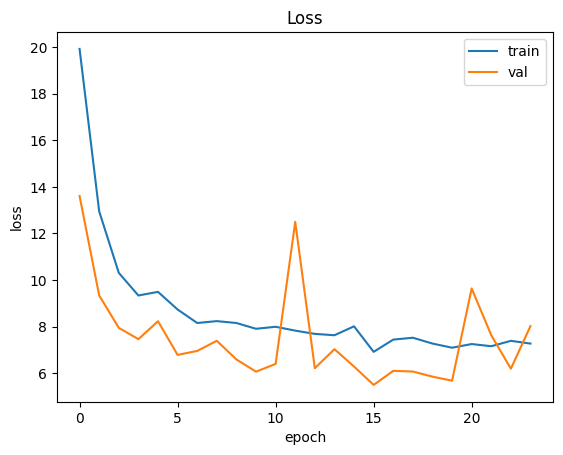

In [28]:
# Auto-detect & run training (safe). If your variables are not ready, we just print guidance.
def _maybe_get(name):
    return globals().get(name, None)

_model = _maybe_get("model")
_train_loader = _maybe_get("train_loader")
_val_loader = _maybe_get("val_loader")
_num_classes = _maybe_get("num_classes")

if _model is None or _train_loader is None:
    print(
        "⚠️ Skipped auto-run: please ensure `model` and `train_loader` exist, then run:\n"
        "model, history = train_epochs(model, train_loader, val_loader, num_classes=<int>, epochs=50, mix_p=0.2, patience=10)"
    )
else:
    if _num_classes is None:
        try:
            last = getattr(_model, "fc", None) or getattr(_model, "classifier", None)
            _num_classes = last.out_features if hasattr(last, "out_features") else None
        except Exception:
            _num_classes = None

    print("🚀 Running improved training loop...")
    model, history = train_epochs(
        _model,
        _train_loader,
        _val_loader,
        num_classes=_num_classes,
        epochs=30,
        lr=3e-4,
        weight_decay=1e-4,
        label_smoothing=0.1,
        grad_clip_norm=1.0,
        mix_p=0.2 if _num_classes else 0.0,
        patience=8,
        save_path="best_model.pth"
    )

    try:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(history['train_loss'], label='train')
        if all([isinstance(v, float) and v == v for v in history['val_loss']]):
            plt.plot(history['val_loss'], label='val')
        plt.legend()
        plt.title('Loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    except Exception as e:
        print("Plot skipped:", e)
